In [1]:
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import calcos
import costools
#from costools import splittag

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

The following tasks in the costools package can be run with TEAL:
         splittag                 timefilter                 x1dcorr


In [2]:
path = '/media/david/5tb_storage1/cc_cet/hst/'

In [3]:
tags = glob.glob(path+'data/*corrtag*')
tags

['/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xkq_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xkq_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xsq_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xsq_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xvq_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xvq_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xxq_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc01xxq_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p5q_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p5q_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p7q_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p7q_corrtag_b.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p9q_corrtag_a.fits',
 '/media/david/5tb_storage1/cc_cet/hst/data/ldlc51p9q_corrtag_b.fits',
 '/med

In [4]:
outpath = path + 'newtags/'

In [5]:
tbin = 30
#for tag in tags:
 #   rootname = fits.getheader(tag,0)['ROOTNAME']
  #  costools.splittag.splittag(tag, '{}{}_split{}s'.format(outpath, rootname, tbin), increment=tbin)

In [6]:
newtags = glob.glob(outpath+'*'+str(tbin)+'*corrtag_a*')

In [7]:
os.environ['lref'] = '{}/data'.format(path)

In [8]:
#for tag in newtags:
 #   calcos.calcos(tag, outdir=path+'newx1ds/', verbosity=2)
    
#btags = glob.glob(outpath+'*'+str(tbin)+'*corrtag_b*')
#for tag, b  in zip(newtags, btags):
 #   rootname = fits.getheader(tag,0)['ROOTNAME']
    #if rootname not in new_roots:
     #   print('yes')
  #  costools.x1dcorr.x1dcorr([tag, b],  outdir=path+'newx1ds/', verbosity=1)

In [62]:
newx1ds = glob.glob(path+'newx1ds/*{}*x1d.fits'.format(tbin))
len(newx1ds)

128

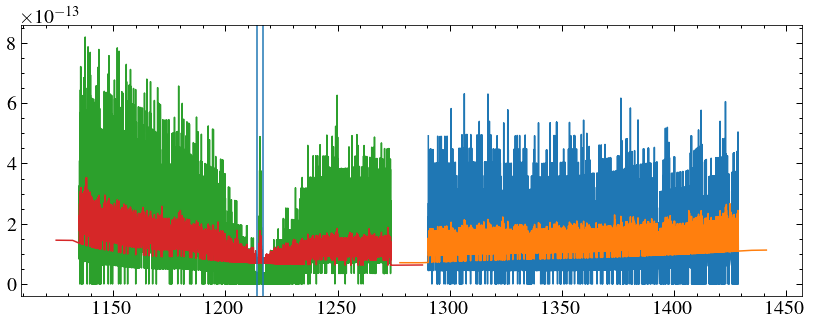

In [63]:
data = fits.getdata(newx1ds[0], 1)
for dt in data:
    #plt.plot(dt['WAVELENGTH'], dt['FLUX'])
    plt.plot(dt['WAVELENGTH'][dt['DQ'] == 0], dt['FLUX'][dt['DQ'] == 0])
    plt.plot(dt['WAVELENGTH'], dt['ERROR'])
lya = [1214, 1217]
[plt.axvline(line) for line in lya]
#plt.xlim(1210, 1220)

In [64]:
#fits.getheader(newx1ds[0], 1)

In [84]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff = np.insert(diff, 0, diff[0]) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff/2.
    w1 = w + diff/2.
    return w0, w1

lya = [1214, 1217]
time = [] #arrays to put the light curve in
flux = []
error = []
for x in newx1ds:
    hdr= fits.getheader(x, 1)
    data = fits.getdata(x,1)
    #ti = (hdr['EXPSTART'] + hdr['EXPEND'])/2
    ti = hdr['EXPEND'] - (hdr['EXPTIME'])/2
    time.append(ti)
    fi = 0
    ei = 0
    for dt in data:
        w, f, e , dq = (dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ'])
        w0, w1 = wavelength_edges(w) 
        mask  = (w < lya[0]) | (w > lya[1]) & (dq == 0)
        w0, w1, f, e = w0[mask], w1[mask], f[mask], e[mask]
        fi += np.sum(f*(w1-w0))
        ei += (np.sum(e**2 * (w1-w0)**2))**0.5
    flux.append(fi)
    error.append(ei)
        
    
time, flux, error = np.array(time), np.array(flux), np.array(error)

time.sort()
        

(170.22, 170.26)

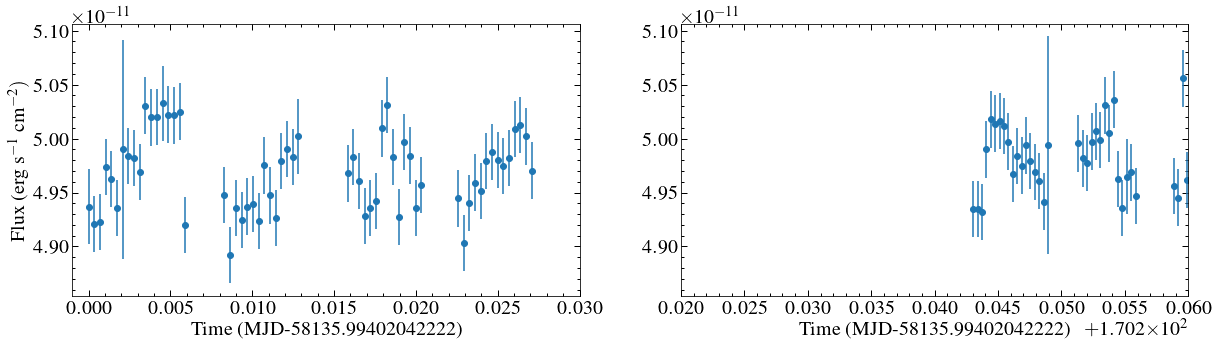

In [85]:

t0 = time[0]
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2})$')
plt.xlabel('Time (MJD-{})'.format(t0))
plt.xlim(-0.001, 0.03)


plt.subplot(122)
plt.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
#plt.ylabel('Flux (erg s$^{-1})$ cm$^{-2})$')
plt.xlabel('Time (MJD-{})'.format(t0))
plt.xlim(170.22, 170.26)

In [87]:
from astropy.table import Table
from astropy.io import ascii
from astropy.units import cds
cds.enable()

save_data = Table([time*cds.MJD, flux/u.s, error/u.s], names = ['TIME', 'FLUX', 'ERROR'])
ascii.write(save_data, '{}_{}s_lc.ecsv'.format('CC_CET_COS', tbin), format = 'ecsv', overwrite=True)

In [86]:
for x in newx1ds:
   # print(x)
    hdr= fits.getheader(x, 1)
    data = fits.getdata(x,1)
   # ti = (hdr['EXPSTART'] + hdr['EXPEND'])/2
    ti = hdr['EXPEND'] - (hdr['EXPTIME'])/2
    rootname = fits.getheader(x, 0)['ROOTNAME']
    wb = np.array([], dtype=float)
    fb = np.array([], dtype=float)
    eb = np.array([], dtype=float)
    dqb = np.array([], dtype=int)
    for dt in data[::-1]:
        w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
       # mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
        #w, f, e = w[mask], f[mask], e[mask]
        wb = np.concatenate((wb, w))
        fb = np.concatenate((fb, f))
        eb = np.concatenate((eb, e))
        dqb = np.concatenate((dqb, dq))
    savdat = Table([wb, fb, eb, dqb], names=['#WAVELENGTH', 'FLUX', 'ERROR', 'DQ'])
    ascii.write(savdat,'{0}30sdats/{1}_{2}_30s.dat'.format(path, rootname, ti), format='basic', overwrite=True)

In [38]:
#fits.getheader(x,0)

(0.0, 50.0)

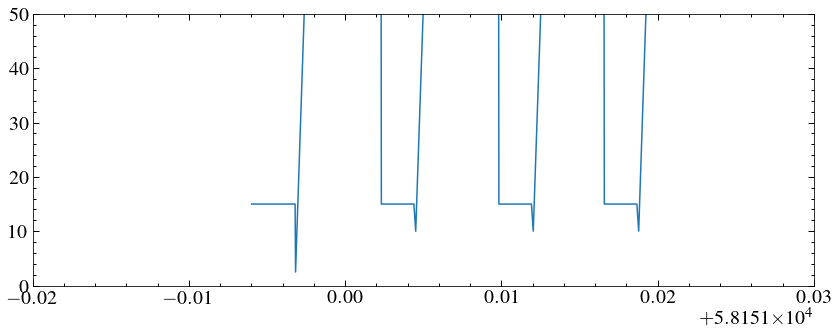

In [69]:

plt.plot(time[1:], np.diff(time)*86400)
plt.xlim(58150.98, 58151.03)
plt.ylim(0, 50)

In [71]:
data = fits.getdata(newx1ds[8],1)


array([30., 30.])

In [72]:
hdr

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =              1409040 / length of dimension 1                          
NAXIS2  =                    2 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   20 / number of table fields                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'ldlc01xxq                         ' / rootname of the observation set
EXPNAME = 'ldlc01xxq        

In [82]:
for x in newx1ds:
   # print(x)
    hdr= fits.getheader(x, 1)
    data = fits.getdata(x,1)
    ti = (hdr['EXPSTART'] + hdr['EXPEND'])/2
    print(hdr['EXPSTART'], hdr['EXPEND'])
    #print((hdr['EXPEND'] - hdr['EXPSTART'])*86400)
    #print(hdr['EXPTIME'])
    print(hdr['EXPEND'] - (hdr['EXPTIME'])/2)

58151.00949468 58151.01458764311
58140.99858764311
58151.00949468 58151.00984190223
58136.00984190223
58151.00949468 58151.01018912445
58136.01018912445
58321.23670802 58321.24052746444
58306.24052746444
58321.23670802 58321.24087468666
58306.24087468666
58150.9936732 58150.99749264444
58135.99749264444
58150.9936732 58150.99998097783
58148.50398097783
58151.00197172 58151.00544394222
58136.00544394222
58321.23670802 58321.24122190889
58306.24122190889
58321.23670802 58321.24156913111
58306.24156913111
58321.24500654 58321.24917320666
58306.24917320666
58321.24500654 58321.24952042889
58306.24952042889
58321.24500654 58321.24986765111
58306.24986765111
58321.24500654 58321.25009950311
58311.234099503105
58321.24500654 58321.24535376222
58306.24535376222
58321.24500654 58321.24570098444
58306.24570098444
58321.24500654 58321.24604820667
58306.24604820667
58150.9936732 58150.99783986666
58135.99783986666
58150.9936732 58150.99818708889
58135.99818708889
58150.9936732 58150.99853431111
58